

 # **Ejercicios prácticos de acceso vía Entrez/E-utilities**

In [1]:
from typing import Optional
from io import StringIO
import json
import requests
import jsonpath_ng.ext as jp
import pandas as pd
from Bio import SeqIO
from lxml import etree
import time
import matplotlib.pyplot as plt

EInfo = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/einfo.fcgi"
ESearch = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
ESummary = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
EFetch = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

In [2]:
def get_einfo(db:Optional[str]= None) -> dict:
    params = { "retmode": "json" }
    if db:
        params.update({"db": db})
    response = requests.get(EInfo, params=params, timeout=10)
    response.raise_for_status()
    return response.json()



# 1. **EInfo: buscar todas las bases de datos disponibles**
 Genera una tabla con:
 - Nombre de la base de datos
 - Descripción
 - Número de registros
 - Fecha de última Actualización.

In [ ]:
all_dbs = [x.value for x  in jp.parse("$..dblist[*]").find(get_einfo())]
all_dbs

In [7]:
all_dbs_data = []
for current_db in all_dbs:
    data = get_einfo(current_db)
    dbname = jp.parse("$..dbname").find(data)[0].value
    description = jp.parse("$..description").find(data)[0].value
    count = jp.parse("$..count").find(data)[0].value
    lastupdate = jp.parse("$..lastupdate").find(data)[0].value
    all_dbs_data.append((dbname, description, count, lastupdate))

table = pd.DataFrame(
    all_dbs_data,
    columns=["name", "description", "count", "lastupdate"]
)

display(table)


,name,description,count,lastupdate
0,pubmed,PubMed bibliographic record,38720832,2025/04/24 20:33
1,protein,Protein sequence record,1447492324,2025/04/24 00:49
2,nuccore,Core Nucleotide db,657965355,2025/04/24 00:03
3,ipg,Identical Protein Groups DB,943145763,2025/04/23 23:03
4,nuccore,Core Nucleotide db,657965355,2025/04/24 00:03
5,structure,Three-dimensional molecular model,235196,2025/04/24 01:52
6,genome,"Genomic sequences, contigs, and maps",88333,2024/11/18 13:03
7,annotinfo,Annotinfo Database,2282,2025/04/24 15:04
8,assembly,Genome Assembly Database,3067635,2025/04/24 11:28
9,bioproject,BioProject Database,883796,2025/04/24 15:44




 ## 2. **Buscar el ID de una secuencia de GenBank por nombre**
 Usa `esearch` para encontrar el **ID** de la secuencia del gen **BRCA1
 humano** en GenBank.

In [2]:
def eSearch(term: str, db: str, retstart=0, retmax=20) -> dict:
    params = {
        "retmode": "json",
        "db":db,
        "term": term,
        "retstart": retstart,
        "retmax": retmax
    }
    response = requests.get(ESearch, params=params, timeout=10)
    response.raise_for_status()
    return response.json()

In [15]:
term = 'BRCA1[Gene Name] AND "Homo sapiens"[Organism] AND BRCA1[Title] AND biomol_genomic[PROP] AND refseq[Filter]'

data = eSearch(term, "nuccore")

n_results = jp.parse("$..count").find(data)[0].value
print(f"Encontré {n_results} resultados")

jp.parse("$..idlist[0]").find(data)[0].value



Encontré 1 resultados


'262359905'



 ## 3. **Obtener el archivo GenBank completo para un Accession ID**
 Usa `efetch` para descargar el archivo GenBank (`retmode=gb`) del gen
 **COX1** de *Homo sapiens*.

In [16]:
term = 'PTGS1[Gene Name] AND "Homo sapiens"[Organism] AND PTGS1[Title] AND biomol_genomic[PROP] AND refseq[Filter]'

data = eSearch(term, "nuccore")

n_results = jp.parse("$..count").find(data)[0].value
print(f"Encontré {n_results} resultados")

identifier = jp.parse("$..idlist[0]").find(data)[0].value

print(identifier)

Encontré 1 resultados
401709987


In [62]:
def efetch(identifier: str, db:str, format:str):
    if format == "ft":
        retmode = "text"
        rettype = "ft"
    if format == "xml":
        retmode = "xml"
        rettype = None
    if format == "fasta":
        retmode = "text"
        rettype = "fasta"
    if format == "genbank":
        retmode = "text"
        rettype = "gb"
    params = {
        "id": identifier,
        "db": db,
        "retmode": retmode,
        "rettype": rettype
    }
    response = requests.get(EFetch, params=params, timeout=10)
    response.raise_for_status()
    return response.content.decode("utf8")

In [20]:
data = efetch(f"{identifier},262359905", "nuccore", "genbank")

In [22]:
with open("cox1.gb", "w", encoding="utf8") as fout:
    fout.write(data)



 ## 4. **Descargar la secuencia en formato FASTA**
 Busca y descarga la secuencia en formato **FASTA** del gen **16S rRNA** de
 *Escherichia coli*.

In [25]:
term = '"16S rRNA"[Gene Name] AND "Escherichia coli"[Organism] AND 16S[Title] AND biomol_genomic[PROP] NOT partial[title]'

data = eSearch(term, "nuccore")

n_results = jp.parse("$..count").find(data)[0].value
print(f"Encontré {n_results} resultados")

identifiers = [x.value for x in jp.parse("$..idlist[*]").find(data)]

print(identifiers)


Encontré 11 resultados
['82617088', '82617077', '82617066', '38091817', '32127561', '1865789', '1865788', '1240024', '1240023', '1240022', '1240021']


In [35]:
data = efetch(",".join(identifiers), "nuccore", format="fasta")

with open("rRNA.coli.fasta", "w", encoding="utf8") as fout:
    fout.write(data)



 ## 5. **Listar Accessions de un organismo**
 Usa `esearch` + `efetch` para listar los **primeros 20 Accessions** de
 secuencias de *Arabidopsis thaliana* en RefSeq.

In [37]:
term = '"Arabidopsis thaliana"[Organism] AND refseq[filter]'

data = eSearch(term, "nuccore")

n_results = jp.parse("$..count").find(data)[0].value

print(f"Encontré {n_results} resultados")

identifiers = [x.value for x in jp.parse("$..idlist[:20]").find(data)]

print(identifiers)



Encontré 53835 resultados
['240256493', '240256243', '240255695', '240254678', '1373662007', '7525012', '2319564279', '1162502463', '1162502461', '1162502459', '1162502457', '1162502455', '1162502453', '1162502451', '1162502449', '1162502447', '1162502442', '1162502440', '1162502438', '1162502436']




 ## 6. **Obtener los metadatos de una secuencia**
 Con `esummary`, extrae información como el título, longitud y fecha de
 publicación para una secuencia dada.

In [4]:
def eSummary(id:str, db:str) -> dict:
    params = {
        "id": id,
        "db": db,
        "retmode": "json"
    }
    response = requests.get(ESummary, params=params, timeout=10)
    response.raise_for_status()
    return response.json()

In [41]:
def get_metadata(id: str):
    data = eSummary(id, "nuccore")
    # print(json.dumps(data, indent=2))
    title = jp.parse("$..title").find(data)[0].value
    seq_length = jp.parse("$..slen").find(data)[0].value
    pub_date = jp.parse("$..createdate").find(data)[0].value
    return {
        "title": title,
        "seq_length": seq_length,
        "pub_date": pub_date
    }

get_metadata("240256243")

{'title': 'Arabidopsis thaliana chromosome 4, partial sequence',
 'seq_length': 18585056,
 'pub_date': '2001/08/13'}



 ## 7. **Buscar genes por palabra clave en la definición**
 Busca secuencias que contengan la palabra "photosystem II" en su definición y
 recupera los primeros 10 Accessions.

In [5]:
term = '"photosystem II"[Title]'

search = eSearch(term, "nuccore")

identifiers = [x.value for x in jp.parse("$..idlist[:10]").find(search)]

identifiers

['1426139044',
 '2960977323',
 '2960968595',
 '2960968266',
 '2960967305',
 '2960960071',
 '2960939538',
 '2960937875',
 '2960936599',
 '2960932392']

In [6]:
summaries = eSummary(",".join(identifiers), "nuccore")


In [ ]:
accession = [x.value for x in jp.parse("$..accessionversion").find(summaries)]
accession

['NM_001364906.1',
 'XM_073439114.1',
 'XM_073434621.1',
 'XM_073434462.1',
 'XM_073433978.1',
 'XM_073425264.1',
 'XM_073414601.1',
 'XM_073413764.1',
 'XM_073413145.1',
 'XM_073460210.1']



 ## 8. **Filtrar por tipo de molécula**
 Busca secuencias de ARN mensajero (**mRNA**) en *Mus musculus* relacionadas
 con "interleukin".

In [9]:
term = 'interleukin AND "Mus musculus"[Organism] AND biomol_mrna[PROP]'

search = eSearch(term, "nuccore")

identifiers = [x.value for x in jp.parse("$..idlist[*]").find(search)]

identifiers

['2650351361',
 '2500537623',
 '2500537612',
 '2500537557',
 '2500537547',
 '2500537546',
 '2074188854',
 '1829010881',
 '1386876226',
 '1386876221',
 '1365036396',
 '1274095997',
 '902763374',
 '894216326',
 '894215975',
 '890787598',
 '890761282',
 '820375847',
 '820375845',
 '735997433']

In [10]:
data = efetch(",".join(identifiers), "nuccore", format="fasta")

In [13]:
with open("mus_musculus.fasta", "w", encoding="utf8") as fout:
    fout.write(data)



 ## 9. **Obtener la traducción de una proteína a partir del CDS**
  Extrae el campo `/translation` de una entrada GenBank que contenga una
  secuencia codificante (CDS).

In [18]:

def get_translations(id:str):
    data = efetch(id, "nuccore", "genbank")
    translations = []
    for record in SeqIO.parse(StringIO(data), format="genbank"):
        cdss = [
            f
            for f in record.features
            if f.type == "CDS"
        ]
        c_translations = [
            cds.qualifiers["translation"]
            for cds in cdss
            if "translation" in cds.qualifiers
        ]
        translations.extend(c_translations)
    return translations

get_translations(1234)

[['QGCGEQTMTLLAPTLAASRYLDKTEQWSLLPPETKDRAVDLIQKGYTRIQEFRKRDGSYGAWLHRDSSTWLTAFVLKILSLAQDQVGGSTKKLQETAMWLLSQQRDDGSFHDPCPVIHRDMQGGLVGSD']]



 ## 10 **Buscar todos los genomas completos de un organismo**
  Encuentra todas las entradas de genomas **completos** de *Mycobacterium
  tuberculosis*.

In [ ]:
term = '"Mycobacterium tuberculosis"[Organism] AND "complete genome"[Title]'

received_ids = [] # Voy a acumular identificadores
total_received = 0
count = 1

it = 0
while total_received < count:
    print("Iteracion:", it)
    it += 1
    data = eSearch(term, "nuccore", retstart=total_received, retmax=100)
    identifiers = [x.value for x in jp.parse("$..idlist[*]").find(data)]
    count = int(jp.parse("$..count").find(data)[0].value)
    print("Count:", count)
    received_ids.extend(identifiers)
    total_received += len(identifiers)
    print("Total:", total_received)

print(len(received_ids))


Iteracion: 0
Count: 867
Total: 100
Iteracion: 1
Count: 867
Total: 200
Iteracion: 2
Count: 867
Total: 300
Iteracion: 3
Count: 867
Total: 400
Iteracion: 4
Count: 867
Total: 500
Iteracion: 5
Count: 867
Total: 600
Iteracion: 6
Count: 867
Total: 700
Iteracion: 7
Count: 867
Total: 800
Iteracion: 8
Count: 867
Total: 867
867


In [33]:
print(len(received_ids))

867




 ## 11. **Extraer estadísticas de longitud**
  Descarga 100 secuencias de genes de *Saccharomyces cerevisiae* y calcula la
  distribución de longitudes.

In [48]:
term = '"Saccharomyces cerevisiae"[Organism]'

search = eSearch(term, "gene", retmax=100)

identifiers = [x.value for x in jp.parse("$..idlist[*]").find(search)]

print(identifiers)

['854976', '851752', '856831', '853507', '850504', '852457', '856709', '851415', '856891', '851520', '852295', '852876', '852088', '852433', '850633', '855700', '855950', '855228', '851259', '855828', '850803', '853568', '855836', '853167', '852294', '855005', '855505', '850620', '856425', '855625', '855264', '851803', '854324', '850518', '855636', '854068', '852385', '853529', '852822', '855492', '850370', '852702', '855471', '854063', '855053', '856862', '850930', '855701', '851163', '855819', '852639', '850585', '854156', '851811', '856236', '851810', '856085', '851456', '855328', '854198', '856478', '852190', '855936', '851561', '852028', '855661', '855386', '853747', '855459', '854465', '854941', '856399', '852200', '854644', '853353', '851191', '852713', '852250', '851306', '854162', '850768', '855949', '851813', '856912', '851431', '852806', '855224', '854583', '854598', '852169', '851266', '850445', '853503', '852308', '853418', '851076', '855104', '852423', '853327', '852265']

In [41]:
import time
all_data ={}
for identifier in identifiers:
    time.sleep(1)
    data = efetch(identifier, "gene", format="xml")
    all_data[identifier] = data

In [55]:

rows = []
for cid, c_data in all_data.items():
    root = etree.parse(StringIO(c_data))
    seq_accession = root.xpath(".//Entrezgene_locus/Gene-commentary/Gene-commentary_accession/text()")
    seq_from = root.xpath(".//Entrezgene_locus/Gene-commentary/Gene-commentary_seqs//Seq-interval_from/text()")
    seq_to = root.xpath(".//Entrezgene_locus/Gene-commentary/Gene-commentary_seqs//Seq-interval_to/text()")
    gene_length = abs(int(seq_from[0])-int(seq_to[0]))+1
    rows.append([seq_accession[0], int(seq_from[0]), int(seq_to[0]), gene_length])

In [56]:

sacc_table = pd.DataFrame(rows, columns = ["accession", "from", "to", "len"])

sacc_table

,accession,from,to,len
0,NC_001145,212514,213929,1416
1,NC_001136,808323,810380,2058
2,NC_001137,349979,351181,1203
3,NC_001142,526334,526663,330
4,NC_001138,53259,54695,1437
...,...,...,...,...
95,NC_001144,849865,852018,2154
96,NC_001145,426711,429626,2916
97,NC_001134,488904,490391,1488
98,NC_001142,196286,197125,840


(array([18., 21., 24., 13.,  6.,  5.,  5.,  2.,  0.,  0.,  3.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  312. ,   940.6,  1569.2,  2197.8,  2826.4,  3455. ,  4083.6,
         4712.2,  5340.8,  5969.4,  6598. ,  7226.6,  7855.2,  8483.8,
         9112.4,  9741. , 10369.6, 10998.2, 11626.8, 12255.4, 12884. ]),
 <BarContainer object of 20 artists>)

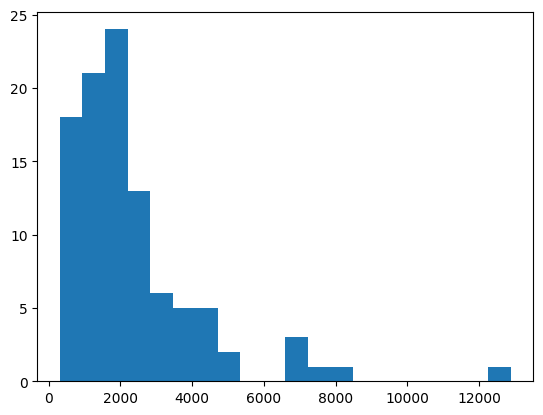

In [57]:

fig, axes = plt.subplots()
axes.hist(sacc_table.len, bins=20)



 ## 12. **Buscar entradas con anotaciones específicas**
 Buscar 10 entradas que tengan el qualifier
 `/product="cytochrome c oxidase subunit I"`
  y guarda sus FASTA en archivos separados.

In [58]:
# /product == Prot Name o Gene Name

term = '"cytochrome c oxidase subunit I"[Prot name]'

search = eSearch(term, "nuccore", retmax=10)

identifiers = [x.value for x in jp.parse("$..idlist[*]").find(search)]

for i in identifiers:
    data = efetch(i, "nuccore", format="fasta")
    with open(f"{i}.fasta", "w", encoding="utf8") as fout:
        fout.write(data)
    data = efetch(i, "nuccore", format="genbank")
    with open(f"{i}.gb", "w", encoding="utf8") as fout:
        fout.write(data)



 ## 13. **Número de registros en el tiempo**
 Usa `esearch` para contar el número de registros en GenBank de secuencias de
 genomas completos de HIV1 por mes desde 1986 hasta la actualidad. Elimina
 todas aquellas que en el título diga "UNVERIFIED".

In [ ]:
import itertools

counts = []
for year, month in itertools.product(range(1986,2026), range(1,13)):
    term = f'txid11676[organism] AND "{year}/{month:02d}"[Publication Date] AND "complete genome"[Title]'
    time.sleep(0.01)
    search = eSearch(term, "nuccore")
    c_counts = int(jp.parse("$..count").find(search)[0].value)
    counts.append([f"{year}/{month:02d}", c_counts])

counts

In [59]:
counts

[['1986/01', 0],
 ['1986/02', 0],
 ['1986/03', 0],
 ['1986/04', 0],
 ['1986/05', 0],
 ['1986/06', 0],
 ['1986/07', 0],
 ['1986/08', 0],
 ['1986/09', 0],
 ['1986/10', 0],
 ['1986/11', 1],
 ['1986/12', 0],
 ['1987/01', 0],
 ['1987/02', 0],
 ['1987/03', 0],
 ['1987/04', 0],
 ['1987/05', 0],
 ['1987/06', 0],
 ['1987/07', 0],
 ['1987/08', 0],
 ['1987/09', 0],
 ['1987/10', 0],
 ['1987/11', 0],
 ['1987/12', 0],
 ['1988/01', 0],
 ['1988/02', 0],
 ['1988/03', 0],
 ['1988/04', 0],
 ['1988/05', 0],
 ['1988/06', 0],
 ['1988/07', 0],
 ['1988/08', 0],
 ['1988/09', 0],
 ['1988/10', 0],
 ['1988/11', 0],
 ['1988/12', 0],
 ['1989/01', 0],
 ['1989/02', 0],
 ['1989/03', 0],
 ['1989/04', 0],
 ['1989/05', 0],
 ['1989/06', 2],
 ['1989/07', 0],
 ['1989/08', 0],
 ['1989/09', 0],
 ['1989/10', 0],
 ['1989/11', 0],
 ['1989/12', 0],
 ['1990/01', 0],
 ['1990/02', 0],
 ['1990/03', 0],
 ['1990/04', 0],
 ['1990/05', 0],
 ['1990/06', 0],
 ['1990/07', 0],
 ['1990/08', 0],
 ['1990/09', 1],
 ['1990/10', 0],
 ['1990/11', 0

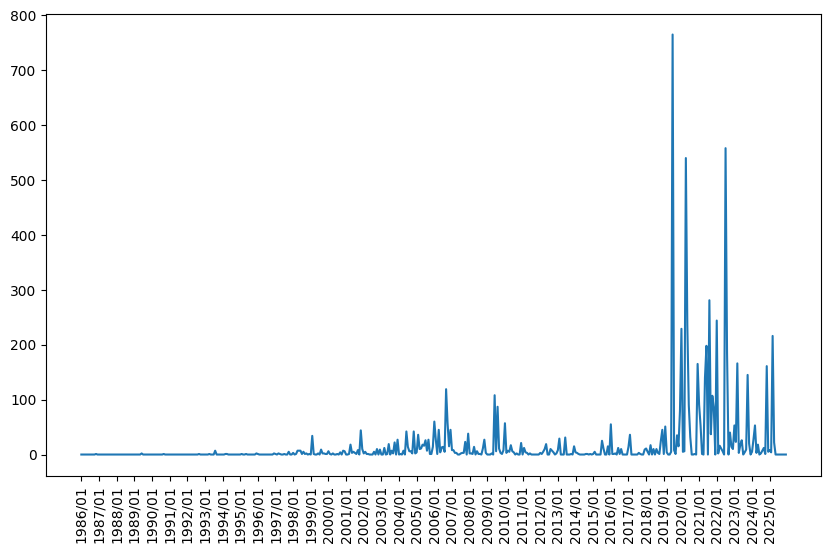

In [60]:
fig, axes = plt.subplots(figsize=(10, 6))
axes.plot(
    range(len(counts)),
    [x[1] for x in counts]
)
axes.set_xticks([x for x in range(len(counts)) if x % 12 == 0])
_ = axes.set_xticklabels(
    [x[0]  for x in counts if x[0].endswith("01")],
    rotation=90
)



 ## 14. **Comparar Tabla de CDS**
 Descarga las tablas de features para todos genomas mitocondriales completos
 de C. elegans y compara sus CDS. ¿Cuántos son iguales?
 ¿Cuántos son diferentes?

In [61]:
term = '"Caenorhabditis elegans"[Organism] AND "complete genome"[title] AND mitochondrion[filter]'

search = eSearch(term, "nuccore")

identifiers = [x.value for x in jp.parse("$..idlist[*]").find(search)]
identifiers



['2949608238', '5834884', '2112362718', '1604722011']

In [63]:
all_ft = []
for i in identifiers:
    data = efetch(i, "nuccore", "ft")
    all_ft.append(data)

In [64]:
print(all_ft[1])

>Feature ref|NC_001328.1|
1	55	gene
			locus_tag	KEF34_t01
			db_xref	GeneID:64984871
1	55	tRNA
			product	tRNA-Pro
58	112	gene
			locus_tag	KEF34_t02
			db_xref	GeneID:64984856
58	112	tRNA
			product	tRNA-Val
113	547	gene
			gene	ND6
			locus_tag	KEF34_p12
			db_xref	GeneID:2565699
113	547	CDS
			product	NADH dehydrogenase subunit 6
			transl_table	5
			protein_id	ref|NP_006953.1|ND6_10021|gnl|NCBI_MITO|ND6_10021
			db_xref	UniProtKB/Swiss-Prot:P24885
549	782	gene
			gene	ND4L
			locus_tag	KEF34_p11
			db_xref	GeneID:2565694
549	782	CDS
			product	NADH dehydrogenase subunit 4L
			transl_table	5
			protein_id	ref|NP_006954.1|ND4L_10021|gnl|NCBI_MITO|ND4L_10021
785	841	gene
			locus_tag	KEF34_t03
			db_xref	GeneID:64984848
785	841	tRNA
			product	tRNA-Trp
842	897	gene
			locus_tag	KEF34_t04
			db_xref	GeneID:64984857
842	897	tRNA
			product	tRNA-Glu
898	1594	gene
			locus_tag	KEF34_r02
			db_xref	GeneID:64984858
898	1594	rRNA
			product	s-rRNA
1595	1647	gene
			locus_tag	KEF34_t05
			db

In [65]:

def ft_to_dataframe(ft:str) -> Optional[pd.DataFrame]:
    lines = ft.split("\n")
    lines = [l for l in lines if not l.startswith(">")]
    last_feat = None
    new_lines = []
    for line in lines:
        fields = line.split("\t")
        if len(fields) == 3:
            last_feat = fields
            continue
        if len(fields) == 5:
            fields = last_feat + fields[3:5]
            new_lines.append(fields)
    if not new_lines:
        return None
    return pd.DataFrame(
        new_lines,
        columns=["start", "end", "feature", "qualifier", "value"]
    )

ft_tables = [
    ft_to_dataframe(x)
    for x in all_ft
]

ft_tables




[None,
      start    end       feature  qualifier                        value
 0        1     55          gene  locus_tag                    KEF34_t01
 1        1     55          gene    db_xref              GeneID:64984871
 2        1     55          tRNA    product                     tRNA-Pro
 3       58    112          gene  locus_tag                    KEF34_t02
 4       58    112          gene    db_xref              GeneID:64984856
 ..     ...    ...           ...        ...                          ...
 151  11691  13274           CDS    db_xref  UniProtKB/Swiss-Prot:P24896
 152  13275  13328          gene  locus_tag                    KEF34_t22
 153  13275  13328          gene    db_xref              GeneID:64984855
 154  13275  13328          tRNA    product                     tRNA-Ala
 155  13329  13794  misc_feature       note                    AT-region
 
 [156 rows x 5 columns],
 None,
 None]

## 15. **Recuperar genes en region cromosómica**

Recupera los nombre de todos los genes que se encuentran en el cromosoma 10,
entre las posiciones 100000 y 1000000 en humanos y en ratón.



In [66]:
term = '("homo sapiens"[Organism] OR "mus musculus"[ORGANISM]) AND 10[Chromosome] AND 100000:1000000[Base Position]'

search = eSearch(term, "gene", retmax=100)

identifiers = [x.value for x in jp.parse("$..idlist[*]").find(search)]
identifiers

['23560',
 '10771',
 '23185',
 '22982',
 '100847086',
 '414235',
 '101927762',
 '106480761',
 '106479497',
 '106479003',
 '101930421',
 '100421369',
 '106783507',
 '111589206',
 '129662603',
 '127816992',
 '132090803',
 '129662604',
 '126860807',
 '126860806',
 '126860805',
 '126860804',
 '126860803',
 '126860802',
 '124403897',
 '111832674',
 '130003159',
 '130003158',
 '130003157',
 '130003156',
 '130003155',
 '130003154',
 '130003153',
 '127816998',
 '127816997',
 '127816996',
 '127816995',
 '127816994',
 '127816993',
 '127816991',
 '127816990',
 '127816989',
 '127816988',
 '127816987',
 '127816986',
 '127816985',
 '127816984',
 '127816983',
 '127816982',
 '127816981',
 '127816980',
 '127816979',
 '127816978',
 '127816977',
 '127816976',
 '127816975',
 '127816974',
 '127816973',
 '127816972',
 '127816971',
 '127816970',
 '127816969',
 '127816968',
 '127816967',
 '127816966',
 '127816965',
 '127816964',
 '127816963',
 '127816962',
 '127816961',
 '127816960',
 '127816959',
 '127816958

In [67]:

summaries = eSummary(",".join(identifiers), 'gene')

In [68]:
data = []
for i in identifiers:
    query = f'$..["{i}"].uid'
    uid = jp.parse(query).find(summaries)[0].value
    query = f'$..["{i}"].description'
    description = jp.parse(query).find(summaries)[0].value
    query = f'$..["{i}"].name'
    name = jp.parse(query).find(summaries)[0].value
    organism = jp.parse(f'$..["{i}"].organism.scientificname').find(summaries)[0].value
    data.append((uid, name, description, organism))

chr10_table = pd.DataFrame(data, columns=["uid", "name", "description", "scientific_name"])
chr10_table

,uid,name,description,scientific_name
0,23560,GTPBP4,GTP binding protein 4,Homo sapiens
1,10771,ZMYND11,zinc finger MYND-type containing 11,Homo sapiens
2,23185,LARP4B,La ribonucleoprotein 4B,Homo sapiens
3,22982,DIP2C,disco interacting protein 2 homolog C,Homo sapiens
4,100847086,MIR5699,microRNA 5699,Homo sapiens
...,...,...,...,...
76,107984285,LOC107984285,uncharacterized LOC107984285,Homo sapiens
77,107984191,LOC107984191,uncharacterized LOC107984191,Homo sapiens
78,107984190,LOC107984190,uncharacterized LOC107984190,Homo sapiens
79,105376341,LOC105376341,uncharacterized LOC105376341,Homo sapiens


## 16. **Recuperar variantes**

Recuperar cuantas variantes existen para el gen FUS humano en la base de datos
dbVar, que tengan una frecuencia alélica global menor al 1%.



In [69]:
term = 'FUS[Gene] AND human[ORGANSIM] AND 0:0.01[Global Allele Frequency]'

search = eSearch(term, "dbVar")

total_variants = jp.parse("$..count").find(search)[0].value
total_variants

'58'